In [1]:
from google.colab import drive, files
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing import image
import time

student_id = 404488
np.random.seed(student_id)
tf.random.set_seed(student_id)

In [2]:
drive.flush_and_unmount
drive.mount('/content/drive')
!unzip -q '/content/drive/MyDrive/rock-paper-scissors.zip' -d '/content/drive/MyDrive/gesture_dataset'

Mounted at /content/drive
replace /content/drive/MyDrive/gesture_dataset/Rock-Paper-Scissors/test/paper/testpaper01-00.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [3]:
#load images from properly formated directories
data_dir = '/content/drive/MyDrive/gesture_dataset'
train_dir = os.path.join(data_dir, 'Rock-Paper-Scissors', 'train')
test_dir = os.path.join(data_dir, 'Rock-Paper-Scissors', 'test')

In [4]:
img_height = 224
img_width = 224
batch_size = 32

train_ds_full = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=(img_height, img_width),
    batch_size=None,
    shuffle=False,
    seed=student_id
)

test_ds_full = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=(img_height, img_width),
    batch_size=None,
    shuffle=False,
    seed=student_id
)

class_names = train_ds_full.class_names
print(f"Classes: {class_names}")

Found 2520 files belonging to 3 classes.
Found 372 files belonging to 3 classes.
Classes: ['paper', 'rock', 'scissors']


In [5]:
#combine into 1 dataset
all_images = train_ds_full.concatenate(test_ds_full)
#shuffle images
all_images = all_images.shuffle(buffer_size=1000, seed=student_id)

In [6]:
#get total size
total_size = len(list(all_images))
print(f"Total dataset size: {total_size}")

#get data set sizes
train_size = int(0.7 * total_size)
val_size = int(0.1 * total_size)
test_size = total_size - train_size - val_size

#create the splits
train_ds = all_images.take(train_size).batch(batch_size)
remaining = all_images.skip(train_size)
val_ds = remaining.take(val_size).batch(batch_size)
test_ds = remaining.skip(val_size).batch(batch_size)

Total dataset size: 2892


In [7]:
print("Data set sizes:")
print(f"Training set: {tf.data.experimental.cardinality(train_ds)}")
print(f"Validation set: {tf.data.experimental.cardinality(val_ds)}")
print(f"Test set: {tf.data.experimental.cardinality(test_ds)}")

Data set sizes:
Training set: 64
Validation set: 10
Test set: 19


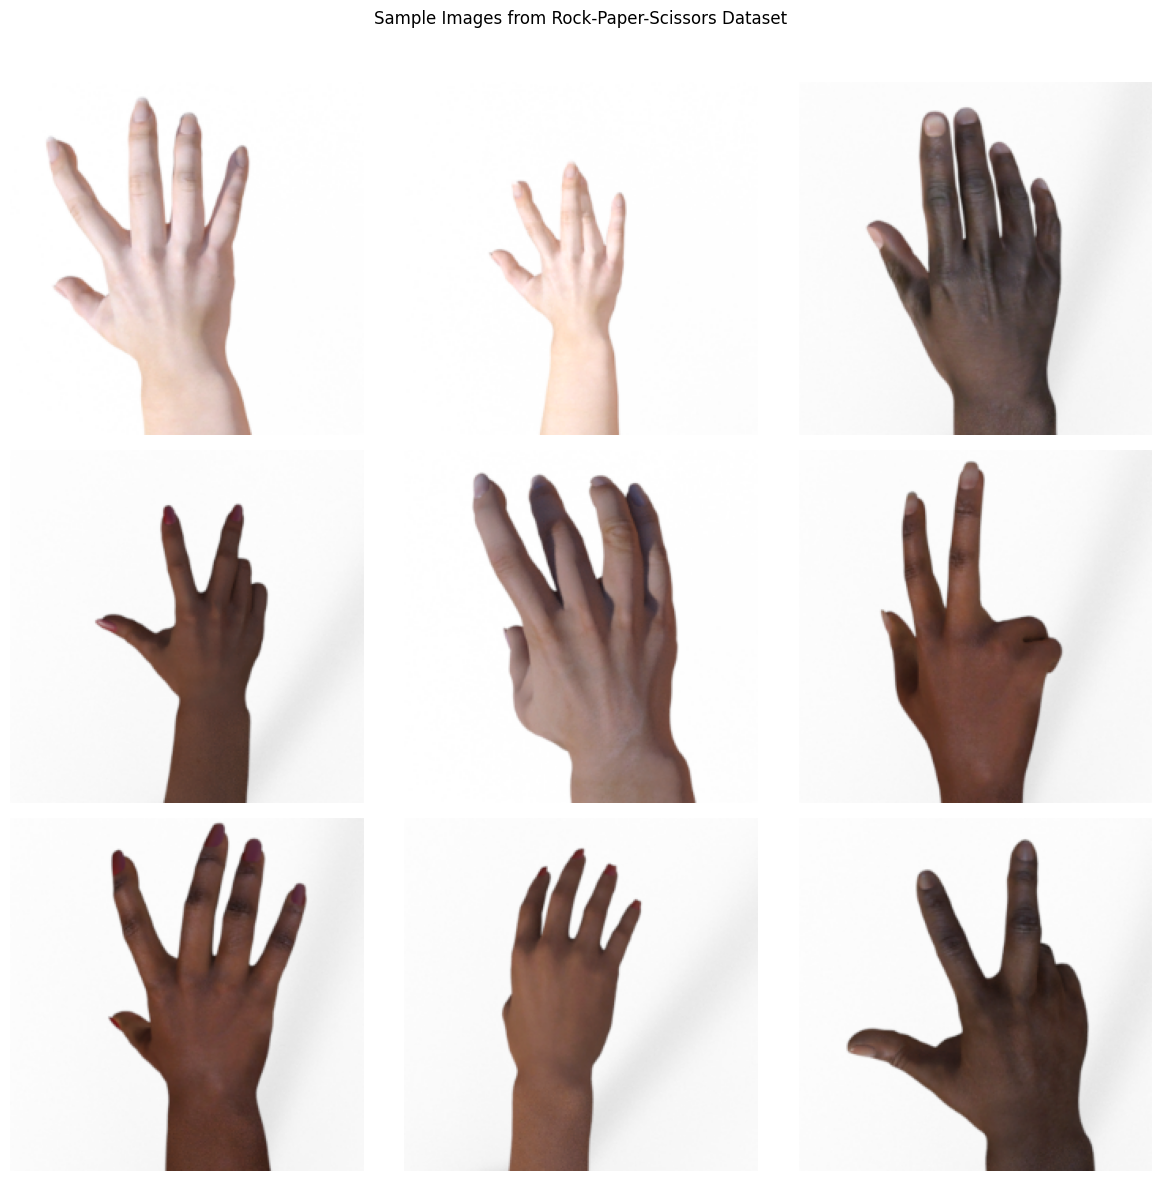

In [8]:
#visualise sample images
plt.figure(figsize=(12, 12))
plt.suptitle("Sample Images from Rock-Paper-Scissors Dataset")

#get a batch of images from the training dataset
for images, labels in train_ds.take(50):
    for i in range(min(9, len(images))):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.axis("off")
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [9]:
#visualise class distribution
def count_examples_per_class(dataset):
    class_counts = [0] * len(class_names)
    for _, labels in dataset:
        for label in labels:
            class_counts[label] += 1
    return class_counts

#calculate class distribution in each split
train_counts = count_examples_per_class(train_ds)
val_counts = count_examples_per_class(val_ds)
test_counts = count_examples_per_class(test_ds)

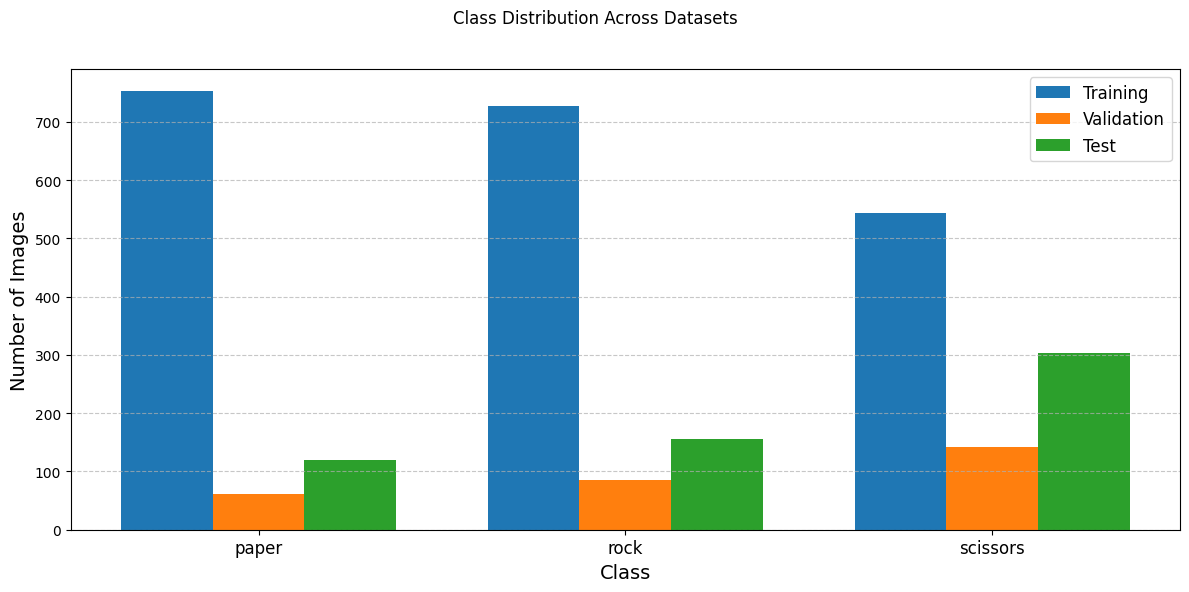

In [10]:
# Plot class distribution
plt.figure(figsize=(12, 6))
plt.suptitle("Class Distribution Across Datasets")
x = np.arange(len(class_names))
width = 0.25

plt.bar(x - width, train_counts, width, label='Training')
plt.bar(x, val_counts, width, label='Validation')
plt.bar(x + width, test_counts, width, label='Test')

plt.xlabel('Class', fontsize=14)
plt.ylabel('Number of Images', fontsize=14)
plt.xticks(x, class_names, fontsize=12)
plt.legend(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

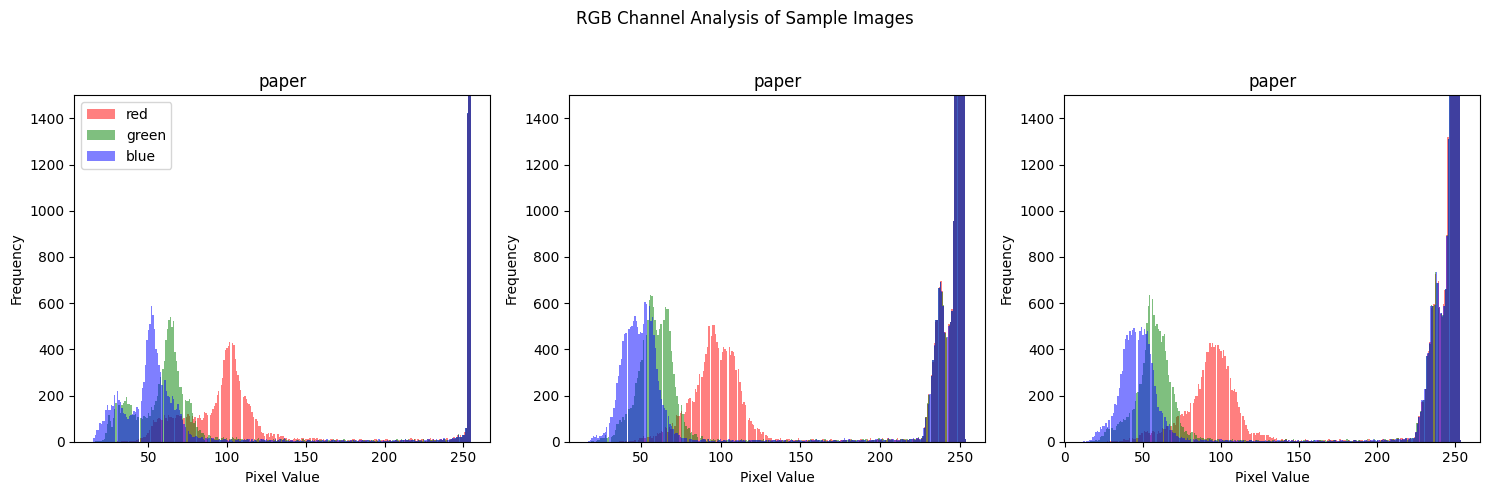

In [11]:
#visualize image characteristics (RGB channels)
plt.figure(figsize=(15, 5))
plt.suptitle("RGB Channel Analysis of Sample Images")

for images, labels in train_ds.take(1):
    for i in range(3):
        img = images[i].numpy().astype("uint8")
        class_label = class_names[labels[i]]

        plt.subplot(1, 3, i+1)

        #plot RGB histograms
        for j, color in enumerate(['red', 'green', 'blue']):
            histogram = plt.hist(img[:,:,j].flatten(), bins=256, alpha=0.5, color=color, label=color)

        plt.title(f"{class_label}")
        plt.xlabel("Pixel Value")
        plt.ylabel("Frequency")
        if i == 0:
            plt.legend()
        plt.ylim(0, 1500)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# 3 initial models
Here we test 3 models a baseline a deeper model and a wider model to see which generalises better

## Basline model

In [12]:
#simple baseline CNN
baseline_model = models.Sequential([
    #first convolutional block
    layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(224, 224, 3)),
    layers.MaxPooling2D((2, 2)),

    #second convolutional block
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),

    #flatten and dense layers
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(3, activation='softmax')
])

#compile model
baseline_model.compile(
    optimizer = 'adam',
    loss = 'sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("baseline CNN architecture")
baseline_model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


baseline CNN architecture


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 200704)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    25,690,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,710,019 (98.08 MB)

 Trainable params: 25,710,019 (98.08 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
#train the model
#callback for early stopping
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

print("Baseline model")
start_time = time.time()
baseline_history = baseline_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15,
    callbacks=[early_stop]
)

baseline_time = time.time() - start_time
print(f"\nBaseline train time: {baseline_time} seconds")

baseline_val_loss, baseline_val_acc = baseline_model.evaluate(val_ds)
print(f"Baseline model val accuracy: {baseline_val_acc:.4f}")

Baseline model
Epoch 1/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 18s 175ms/step - accuracy: 0.5803 - loss: 1484.2400 - val_accuracy: 0.8097 - val_loss: 0.4591
Epoch 2/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 9s 116ms/step - accuracy: 0.8746 - loss: 0.3154 - val_accuracy: 0.8997 - val_loss: 0.2959
Epoch 3/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 9s 115ms/step - accuracy: 0.9549 - loss: 0.1275 - val_accuracy: 0.9343 - val_loss: 0.1807
Epoch 4/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 9s 115ms/step - accuracy: 0.9951 - loss: 0.0231 - val_accuracy: 0.9550 - val_loss: 0.1179
Epoch 5/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 9s 116ms/step - accuracy: 0.9979 - loss: 0.0111 - val_accuracy: 0.9585 - val_loss: 0.0976
Epoch 6/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 9s 113ms/step - accuracy: 0.9961 - loss: 0.0107 - val_accuracy: 0.9827 - val_loss: 0.0576
Epoch 7/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 9s 115ms/step - accuracy: 0.9918 - loss: 0.0172 - val_accuracy: 0.9965 - val_loss: 0.0310
Epoch 8/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 9s 116ms/step - accuracy: 0.9999 - loss: 0.0021

## Deeper Model

In [14]:
#create a deeper CNN model
deeper_model = models.Sequential([
    #first convolutional block
    layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(224, 224, 3)),
    layers.BatchNormalization(),
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),

    #second convolutional block
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),

    #third convolutional block
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(3, activation='softmax')
])

#compile the model
deeper_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

#print model summary
print("Deeper CNN Architecture:")
deeper_model.summary()

Deeper CNN Architecture:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 224, 224, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 112, 112, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 56, 56, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │    25,690,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,979,043 (99.10 MB)

 Trainable params: 25,978,595 (99.10 MB)

 Non-trainable params: 448 (1.75 KB)

In [15]:
#train the deeper model
print("Deeper model")
start_time = time.time()

deeper_history = deeper_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15,
    callbacks=[early_stop]
)

deeper_training_time = time.time() - start_time
print(f"\nDeeper model training time: {deeper_training_time:.2f} seconds")

#evaluate on validation set
deeper_val_loss, deeper_val_acc = deeper_model.evaluate(val_ds)
print(f"Deeper model validation accuracy: {deeper_val_acc:.4f}")

Deeper model
Epoch 1/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 39s 350ms/step - accuracy: 0.7204 - loss: 12.8635 - val_accuracy: 0.2837 - val_loss: 15.3553
Epoch 2/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 14s 196ms/step - accuracy: 0.6517 - loss: 0.7225 - val_accuracy: 0.5260 - val_loss: 3.5264
Epoch 3/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 14s 197ms/step - accuracy: 0.9060 - loss: 0.2283 - val_accuracy: 0.5986 - val_loss: 1.0864
Epoch 4/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 14s 199ms/step - accuracy: 0.9491 - loss: 0.1330 - val_accuracy: 0.9654 - val_loss: 0.1467
Epoch 5/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 14s 197ms/step - accuracy: 0.9739 - loss: 0.0838 - val_accuracy: 0.6851 - val_loss: 0.8844
Epoch 6/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 14s 195ms/step - accuracy: 0.9811 - loss: 0.0474 - val_accuracy: 0.9896 - val_loss: 0.0347
Epoch 7/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 14s 193ms/step - accuracy: 0.9721 - loss: 0.0678 - val_accuracy: 0.9446 - val_loss: 0.1406
Epoch 8/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 14s 196ms/step - accuracy: 0.9858 - loss: 0.

## Wider model

In [16]:
#wider CNN model
wider_model = models.Sequential([
    #first convolutional block with more filters
    layers.Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(224, 224, 3)),
    layers.MaxPooling2D((2, 2)),

    #second convolutional block with more filters
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),

    #flatten and wider dense layers
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(3, activation='softmax')
])

#compile the model
wider_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

#print model summary
print("\nWider CNN Architecture:")
wider_model.summary()


Wider CNN Architecture:


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 401408)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │   205,521,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │         1,539 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 205,598,595 (784.30 MB)

 Trainable params: 205,598,595 (784.30 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
#train the wider model
print("Wider model")
start_time = time.time()

wider_history = wider_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15,
    callbacks=[early_stop]
)

wider_training_time = time.time() - start_time
print(f"\nWider model training time: {wider_training_time:.2f} seconds")

#evaluate on validation set
wider_val_loss, wider_val_acc = wider_model.evaluate(val_ds)
print(f"Wider model validation accuracy: {wider_val_acc:.4f}")

Wider model
Epoch 1/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 31s 318ms/step - accuracy: 0.7138 - loss: 1150.4585 - val_accuracy: 0.9412 - val_loss: 0.2078
Epoch 2/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 13s 180ms/step - accuracy: 0.9815 - loss: 0.0568 - val_accuracy: 0.9204 - val_loss: 0.5802
Epoch 3/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 14s 193ms/step - accuracy: 0.9741 - loss: 0.1531 - val_accuracy: 0.9758 - val_loss: 0.1208
Epoch 4/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 14s 194ms/step - accuracy: 0.9949 - loss: 0.0399 - val_accuracy: 0.9862 - val_loss: 0.0701
Epoch 5/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 14s 195ms/step - accuracy: 0.9966 - loss: 0.0150 - val_accuracy: 0.9862 - val_loss: 0.0231
Epoch 6/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 13s 181ms/step - accuracy: 0.9969 - loss: 0.0268 - val_accuracy: 0.9931 - val_loss: 0.0627
Epoch 7/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 14s 195ms/step - accuracy: 0.9996 - loss: 0.0020 - val_accuracy: 0.9965 - val_loss: 0.0090
Epoch 8/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 14s 195ms/step - accuracy: 0.9996 - loss: 0.

## Results

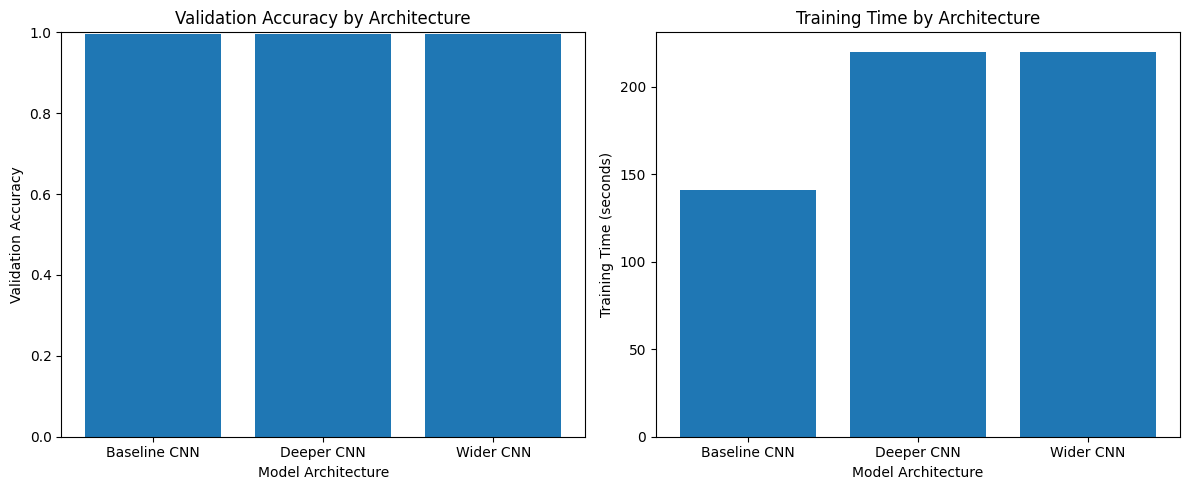


Model Architecture Comparison:
Baseline CNN: Accuracy = 0.9965, Training Time = 140.74 seconds
Deeper CNN: Accuracy = 0.9965, Training Time = 219.99 seconds
Wider CNN: Accuracy = 0.9965, Training Time = 219.90 seconds


In [18]:
# Compare the three model architectures
architecture_comparison = {
    'Model': ['Baseline CNN', 'Deeper CNN', 'Wider CNN'],
    'Validation Accuracy': [baseline_val_acc, deeper_val_acc, wider_val_acc],
    'Training Time (s)': [baseline_time, deeper_training_time, wider_training_time]
}

# Create a bar chart to compare accuracies
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.bar(architecture_comparison['Model'], architecture_comparison['Validation Accuracy'])
plt.title('Validation Accuracy by Architecture')
plt.xlabel('Model Architecture')
plt.ylabel('Validation Accuracy')
plt.ylim(0, 1)  # Set y-axis from 0 to 1 for accuracy

# Create a bar chart to compare training times
plt.subplot(1, 2, 2)
plt.bar(architecture_comparison['Model'], architecture_comparison['Training Time (s)'])
plt.title('Training Time by Architecture')
plt.xlabel('Model Architecture')
plt.ylabel('Training Time (seconds)')

plt.tight_layout()
plt.show()

# Print the comparison as a formatted table
print("\nModel Architecture Comparison:")
for i in range(len(architecture_comparison['Model'])):
    model = architecture_comparison['Model'][i]
    acc = architecture_comparison['Validation Accuracy'][i]
    time = architecture_comparison['Training Time (s)'][i]
    print(f"{model}: Accuracy = {acc:.4f}, Training Time = {time:.2f} seconds")

In [19]:
test_loss_base, test_acc_base = baseline_model.evaluate(test_ds)
test_loss_deep, test_acc_deep = deeper_model.evaluate(test_ds)
test_loss_wide, test_acc_wide = wider_model.evaluate(test_ds)

print("Test accuracy for each model")
print(f"Baseline Model: {test_acc_base}")
print(f"Deeper Model: {test_acc_deep}")
print(f"Wider Model: {test_acc_wide}")

19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - accuracy: 0.9959 - loss: 0.0042
19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 95ms/step - accuracy: 0.9976 - loss: 0.0098
19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 96ms/step - accuracy: 0.9993 - loss: 0.0028
Test accuracy for each model
Baseline Model: 0.9965457916259766
Deeper Model: 0.9982728958129883
Wider Model: 0.9982728958129883


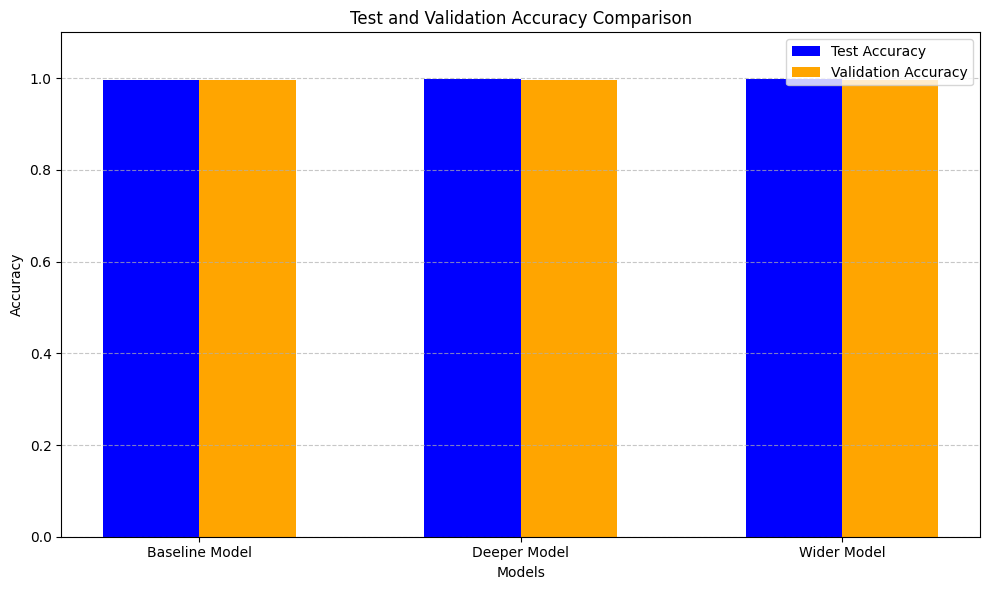

In [20]:
models = ['Baseline Model', 'Deeper Model', 'Wider Model']
test_acc = [test_acc_base, test_acc_deep, test_acc_wide]
val_acc = [baseline_val_acc, deeper_val_acc, wider_val_acc]

barWidth = 0.3
#set bar positions
r1 = np.arange(len(models))
r2 = [x + barWidth for x in r1]

#create the grouped bar chart
plt.figure(figsize=(10, 6))
plt.bar(r1, test_acc, width=barWidth, label='Test Accuracy', color='blue')
plt.bar(r2, val_acc, width=barWidth, label='Validation Accuracy', color='orange')

#add labels and title
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Test and Validation Accuracy Comparison')
plt.xticks([r + barWidth/2 for r in range(len(models))], models)
plt.ylim(0, 1.1)

plt.legend()

#add grid
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

## Test on own images

In [25]:
# Create the directory if it doesn't exist
!mkdir -p /content/my_test_images

# Upload images
from google.colab import files
uploaded = files.upload()

# Save each file with its original name and extension
for fn in uploaded.keys():
   os.rename(fn, f'/content/my_test_images/{fn}')
   print(f"Saved {fn} to /content/my_test_images/{fn}")

# Verify the uploads worked
image_files = [f for f in os.listdir('/content/my_test_images')
              if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
print(f"\nFound {len(image_files)} image files in /content/my_test_images:")
for img in image_files:
    print(f"- {img}")

Saving IMG_3290.jpeg to IMG_3290.jpeg
Saving IMG_3291.jpeg to IMG_3291.jpeg
Saving IMG_3292.jpeg to IMG_3292.jpeg
Saving IMG_3293.jpeg to IMG_3293.jpeg
Saved IMG_3290.jpeg to /content/my_test_images/IMG_3290.jpeg
Saved IMG_3291.jpeg to /content/my_test_images/IMG_3291.jpeg
Saved IMG_3292.jpeg to /content/my_test_images/IMG_3292.jpeg
Saved IMG_3293.jpeg to /content/my_test_images/IMG_3293.jpeg

Found 4 image files in /content/my_test_images:
- IMG_3292.jpeg
- IMG_3293.jpeg
- IMG_3290.jpeg
- IMG_3291.jpeg


In [26]:
# Check if the folder exists
folder_path = '/content/my_test_images'
print(f"Folder exists: {os.path.exists(folder_path)}")

# List contents of the parent directory to verify the folder name
parent_dir = os.path.dirname(folder_path)
print(f"Contents of {parent_dir}:")
print(os.listdir(parent_dir))

# If the folder exists, list its contents
if os.path.exists(folder_path):
    print(f"\nContents of {folder_path}:")
    files = os.listdir(folder_path)
    print(files)

    # Check file extensions
    print("\nFile extensions:")
    for file in files:
        _, ext = os.path.splitext(file)
        print(f"{file}: {ext}")

Folder exists: True
Contents of /content:
['.config', 'drive', 'my_test_images', 'sample_data']

Contents of /content/my_test_images:
['IMG_3292.jpeg', 'IMG_3293.jpeg', 'IMG_3290.jpeg', 'IMG_3291.jpeg']

File extensions:
IMG_3292.jpeg: .jpeg
IMG_3293.jpeg: .jpeg
IMG_3290.jpeg: .jpeg
IMG_3291.jpeg: .jpeg


Found 4 image files: ['IMG_3292.jpeg', 'IMG_3293.jpeg', 'IMG_3290.jpeg', 'IMG_3291.jpeg']


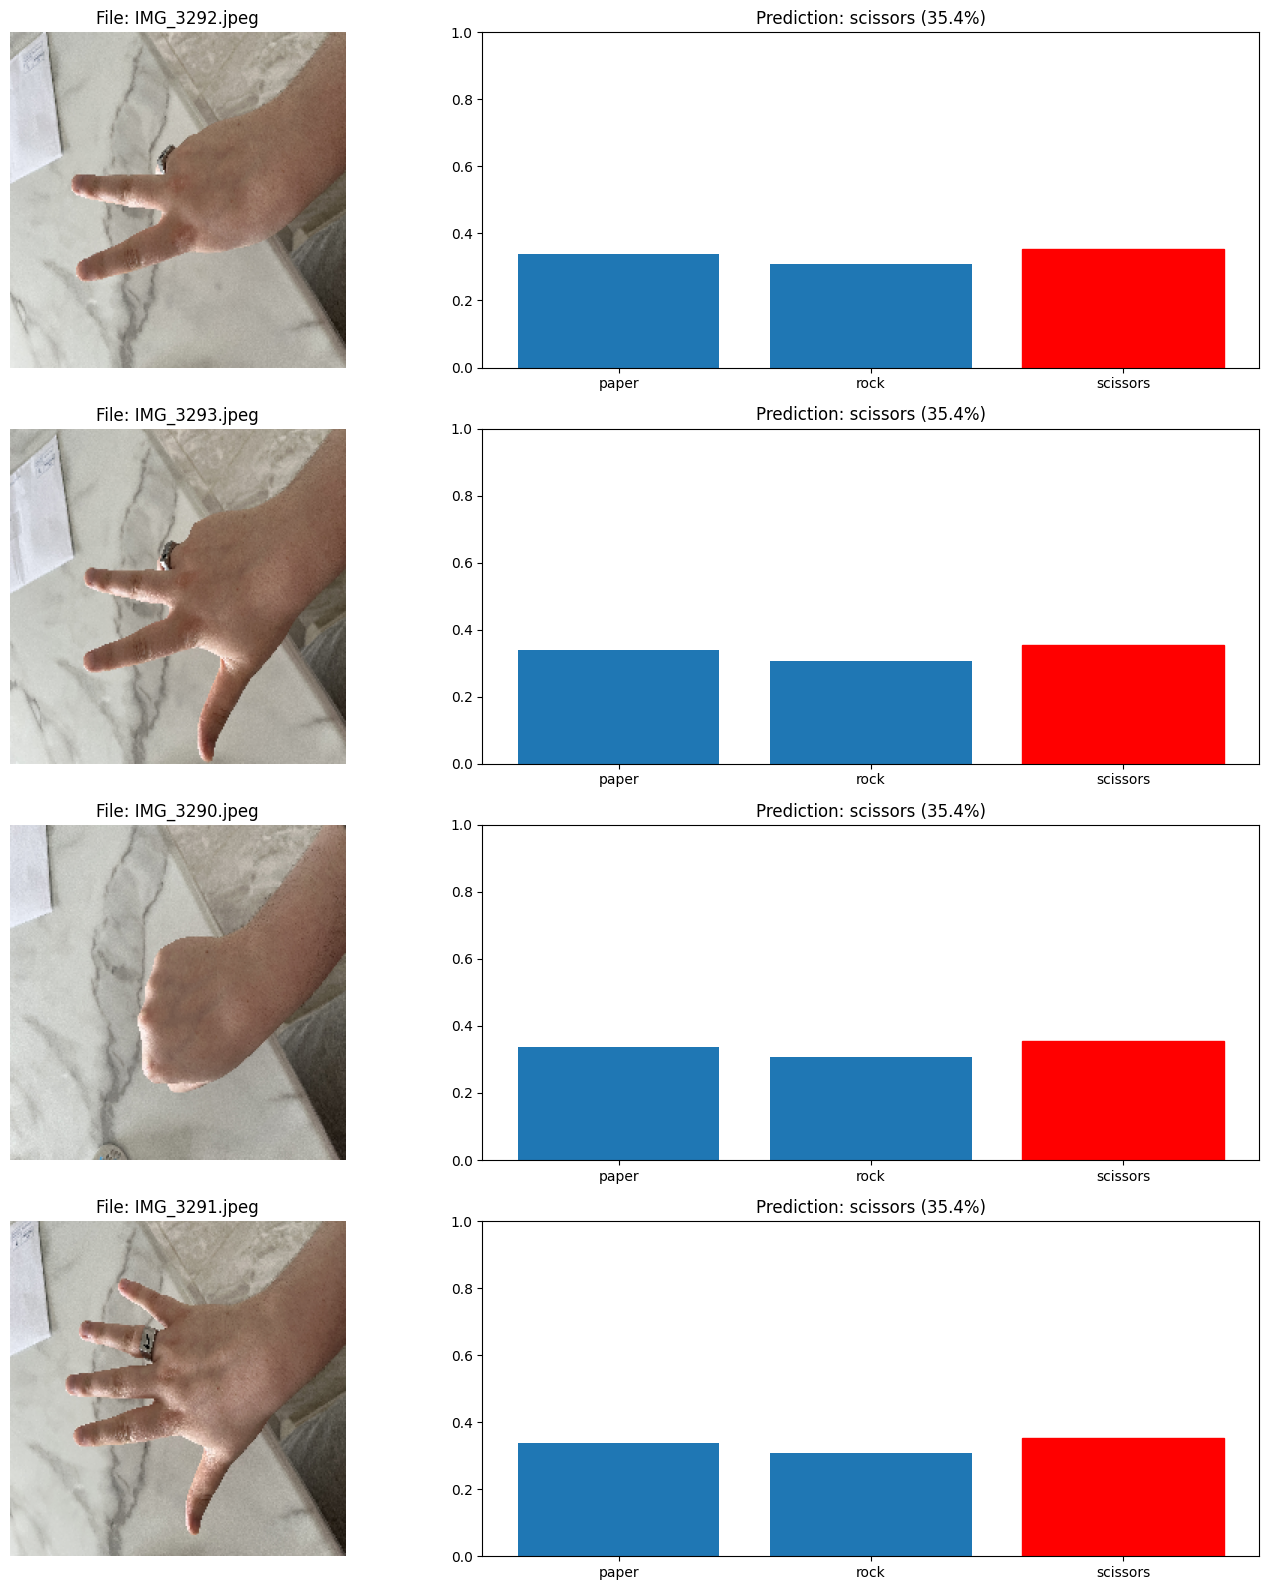

In [28]:
# Define variables
model = baseline_model  # Or whichever model you want to test
image_folder = '/content/my_test_images'  # Path to your test images folder
class_names = ['paper', 'rock', 'scissors']  # Make sure these match your model's classes
image_size = (224, 224)  # Size to resize images to

# Get all image files
image_files = [f for f in os.listdir(image_folder)
              if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

print(f"Found {len(image_files)} image files: {image_files}")

if not image_files:
    print(f"No images found in {image_folder}")
else:
    # Set up the plot
    n_images = len(image_files)
    fig = plt.figure(figsize=(15, 4 * n_images))

    # Process each image
    for i, img_file in enumerate(image_files):
        # Load and preprocess image
        img_path = os.path.join(image_folder, img_file)
        img = image.load_img(img_path, target_size=image_size)
        img_array = image.img_to_array(img)
        img_array = img_array / 255.0  # Normalize to [0,1]
        img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

        # Make prediction
        predictions = model.predict(img_array, verbose=0)
        predicted_class_idx = np.argmax(predictions[0])
        predicted_class = class_names[predicted_class_idx]
        confidence = predictions[0][predicted_class_idx] * 100

        # Display image and prediction
        plt.subplot(n_images, 2, i*2 + 1)
        plt.imshow(img)
        plt.title(f"File: {img_file}")
        plt.axis('off')

        # Display prediction details
        plt.subplot(n_images, 2, i*2 + 2)
        # Create bar chart of predictions
        bars = plt.bar(class_names, predictions[0])
        bars[predicted_class_idx].set_color('red')
        plt.ylim([0, 1.0])
        plt.title(f"Prediction: {predicted_class} ({confidence:.1f}%)")

    plt.tight_layout()
    plt.show()

# Hyperparameters
here we apply different hyperparameters to each model to see if we can improve the models further

## Learning Rate

In [ ]:
learning_rates = [0.01, 0.001, 0.0001]

lr_results = {}

for model_name, model_architecture in [
    ("baseline", baseline_model),
    ("deeper", deeper_model),
    ("wider", wider_model)
]:

  print(f"\ntesting lr for {model_name} model")

  model_results = {}
  for lr in learning_rates:
    print(f"testing lr: {lr}")

    if model_name == "baseline":
      model = baseline_model
    elif model_name == "deeper":
      model = deeper_model
    else:
      model = wider_model

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy'],
    )

    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=10,
        callbacks=[early_stop],
        verbose=1
    )

    test_loss, test_acc = model.evaluate(test_ds)

    model_results[lr] = {
       'test_accuracy': test_acc,
       'history': history.history
    }

    print(f"LR={lr}, Test accuracy={test_acc:.4f}")

  lr_results[model_name] = model_results



testing lr for baseline model
testing lr: 0.01
Epoch 1/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - accuracy: 0.5385 - loss: 1.0478 - val_accuracy: 0.2388 - val_loss: 1.1484
Epoch 2/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 9s 112ms/step - accuracy: 0.5466 - loss: 1.0488 - val_accuracy: 0.1903 - val_loss: 1.1451
Epoch 3/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 8s 109ms/step - accuracy: 0.5486 - loss: 1.0586 - val_accuracy: 0.2630 - val_loss: 1.1399
Epoch 4/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 8s 111ms/step - accuracy: 0.4230 - loss: 1.0549 - val_accuracy: 0.2734 - val_loss: 1.1394
Epoch 5/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 9s 113ms/step - accuracy: 0.4698 - loss: 1.0552 - val_accuracy: 0.3287 - val_loss: 1.1374
Epoch 6/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 8s 107ms/step - accuracy: 0.3856 - loss: 1.0590 - val_accuracy: 0.2111 - val_loss: 1.1364
Epoch 7/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 8s 107ms/step - accuracy: 0.5382 - loss: 1.0573 - val_accuracy: 0.2664 - val_loss: 1.1471
Epoch 8/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 8s 108ms/step - a

In [ ]:
#visualise learning rate results
plt.figure(figsize=(15, 5))
for i, model_name in enumerate(lr_results.keys()):
    plt.subplot(1, 3, i+1)

    for lr, results in lr_results[model_name].items():
        plt.plot(results['history']['val_accuracy'], label=f'LR={lr}')

    plt.title(f'{model_name} Model')
    plt.xlabel('Epoch')
    plt.ylabel('Validation Accuracy')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.suptitle('Effect of Learning Rate on Model Convergence', fontsize=16)
plt.subplots_adjust(top=0.85)
plt.show()

In [ ]:
#create a bar chart of final test accuracies
plt.figure(figsize=(12, 6))
model_names = list(lr_results.keys())
x = np.arange(len(model_names))
width = 0.25

for i, lr in enumerate(learning_rates):
    accuracies = [lr_results[model][lr]['test_accuracy'] for model in model_names]
    plt.bar(x + i*width, accuracies, width, label=f'LR={lr}')

plt.ylabel('Test Accuracy')
plt.title('Impact of Learning Rate on Test Accuracy')
plt.xticks(x + width, model_names)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.ylim(0, 1.1)
plt.show()